In [17]:

import os
import torch
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from torchvision.transforms.v2 import functional as F
from torchvision import transforms
import pandas as pd

%matplotlib inline
torch.cuda.empty_cache()
# class CustomDataset(Dataset):
#     def __init__(self, root_dir, transform=None):
#         self.root_dir = root_dir
#         self.transform = transform
        
#         self.classes = os.listdir(self.root_dir)
#         self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
#         self.paths = []
#         self.labels = []

#         for class_name in self.classes:
#             class_dir = os.path.join(self.root_dir, class_name)
#             for filename in os.listdir(class_dir):
#                 self.paths.append(os.path.join(class_dir, filename))
#                 self.labels.append(self.class_to_idx[class_name])

#     def __len__(self):
#         return len(self.paths)

#     def __getitem__(self, idx):
#         image_path = self.paths[idx]
#         label = self.labels[idx]

#         image = Image.open(image_path)
#         if self.transform:
#             image = self.transform(image)

#         return image, label

In [18]:
print(torch.__version__)

2.1.0+cu118


In [19]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
torch.cuda.empty_cache()

Using cuda device


In [20]:
file_path = 'train_data.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
data.head()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,weld_0001-810-small-0-r.jpg,23653,{},1,0,"{""name"":""rect"",""x"":34,""y"":190,""width"":54,""heig...",{}
1,weld_0001-810-small-1-r.jpg,24230,{},1,0,"{""name"":""rect"",""x"":15,""y"":194,""width"":55,""heig...",{}
2,weld_0001-810-small-1-r-adj.jpg,38088,{},1,0,"{""name"":""rect"",""x"":2,""y"":207,""width"":50,""heigh...",{}
3,weld_0001-820-small-0-l-adj.jpg,41993,{},1,0,"{""name"":""rect"",""x"":153,""y"":159,""width"":53,""hei...",{}
4,weld_0001-820-small-0-r.jpg,23413,{},1,0,"{""name"":""rect"",""x"":34,""y"":152,""width"":56,""heig...",{}


In [21]:
import json

def extract_bounding_box(region_shape_attributes):
    # Load the JSON data
    region_dict = json.loads(region_shape_attributes)

    # Extract coordinates
    xmin = region_dict.get('x', 0)
    ymin = region_dict.get('y', 0)
    width = region_dict.get('width', 0)
    height = region_dict.get('height', 0)

    # Calculate xmax and ymax
    xmax = xmin + width
    ymax = ymin + height

    return ymin, xmin, ymax, xmax

In [22]:
img_size = 64

class CustomImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the CSV file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.data = pd.read_csv(csv_file)

        # Extract unique class names and assign integer labels
        self.classes = self.data['region_attributes'].unique()  # Modify as per the actual column for class labels if different
        self.class_to_int = {c: idx for idx, c in enumerate(self.classes)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx]['filename'])
        image = Image.open(img_name).convert("RGB")
        orig_width, orig_height = image.size
        
        if self.transform:
            image = self.transform(image)

       
        scale_x = img_size / orig_width
        scale_y = img_size / orig_height

        # Extract bounding box coordinates from JSON in 'region_shape_attributes'
        region_shape_attributes = self.data.iloc[idx]['region_shape_attributes']
        region_dict = json.loads(region_shape_attributes)
        xmin = region_dict.get('x', 0) * scale_x
        ymin = region_dict.get('y', 0) * scale_y
        width = region_dict.get('width', 0) * scale_x
        height = region_dict.get('height', 0) * scale_y
        xmax = xmin + width
        ymax = ymin + height
        box = torch.tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32)

        iscrowd = torch.zeros((box.shape[0],), dtype=torch.int64)

        # # Extract label and convert to tensor (modify as per actual data)
        # label_name = self.data.iloc[idx]['region_attributes']  # Modify as per the actual column for class labels if different
        # label = self.class_to_int.get(label_name, 1)
        label_tensor = torch.tensor([0], dtype=torch.int64)
        area = torch.tensor([(xmax - xmin) * (ymax - ymin)], dtype=torch.float64)

        target = {}
        target["boxes"] = box
        target["labels"] = label_tensor
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["image_id"] = torch.tensor([idx])


        return image, target
    
# Example usage:
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),  # Resize should be applied on a PIL Image
    transforms.ToTensor(),  # Convert the PIL Image to a tensor

])




def collate_fn(batch):
    return tuple(zip(*batch))


dataset = CustomImageDataset(csv_file='C:/Users/denis/Desktop/VIR/Projekt/train_data.csv', root_dir='C:/Users/denis/Desktop/VIR/Projekt/train/510/', transform=transform)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True,  collate_fn=collate_fn)

test_dataset = CustomImageDataset(csv_file='C:/Users/denis/Desktop/VIR/Projekt/test_data.csv', root_dir='C:/Users/denis/Desktop/VIR/Projekt/test/510/', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False,  collate_fn=collate_fn)

print('length of train dataset = ', len(dataset), '\n')

length of train dataset =  160 



In [23]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches

# def show_tensor_image_with_box(tensor_image, box):
#     # Convert from tensor to numpy and scale pixel values back to [0-1] if they were normalized
#     numpy_image = tensor_image.permute(1, 2, 0).numpy()
#     numpy_image = numpy_image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
#     numpy_image = numpy_image.clip(0, 1)

#     # Create figure and axes
#     fig, ax = plt.subplots()

#     # Display the image
#     ax.imshow(numpy_image)

#     # Unpack the box coordinates and create a Rectangle patch
#     x_min, y_min, x_max, y_max = box
#     rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')

#     # Add the patch to the Axes
#     ax.add_patch(rect)

#     plt.axis('off')  # Turn off axis
#     plt.show()

# # Assuming train_loader is defined and properly loaded with your dataset
# for images, targets in train_loader:
#     if len(images) > 0:
#         first_image = images[0]
#         first_target = targets[0]

#         box = first_target['boxes'][0].cpu().numpy()  # Assuming 'boxes' is a key in your target dictionary
#         print(box)
#         show_tensor_image_with_box(first_image, box)
#         break


In [24]:
train_images, train_targets = next(iter(train_loader))

# Check a batch from test_loader
test_images, test_targets = next(iter(test_loader))

print(f"Train images shape: {train_images[0].shape}")  # Check the shape of the first image
print(f"Train targets keys: {train_targets[0].keys()}")  # Check the keys of the first target
print(f"Box format: {train_targets[0]['boxes']}")
print(f"Labels: {train_targets[0]['labels']}")
print(f"Image ID: {train_targets[0]['image_id']}")
print(f"Area: {train_targets[0]['area']}")
print(f"Iscrowd: {train_targets[0]['iscrowd']}")


Train images shape: torch.Size([3, 64, 64])
Train targets keys: dict_keys(['boxes', 'labels', 'area', 'iscrowd', 'image_id'])
Box format: tensor([[16.2286,  0.4571, 32.6857, 30.1714]])
Labels: tensor([0])
Image ID: tensor([62])
Area: tensor([489.0122], dtype=torch.float64)
Iscrowd: tensor([0])


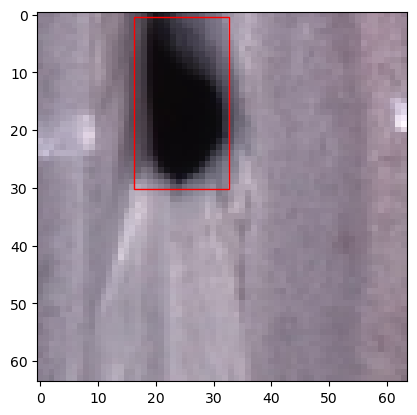

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_image_with_boxes(image, target):
    # Convert tensor image to numpy and display
    numpy_image = image.permute(1, 2, 0).numpy()
    plt.imshow(numpy_image)

    # Add bounding boxes
    for box in target['boxes']:
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)

    plt.show()

# Visualize the first image of the train_loader
show_image_with_boxes(train_images[0], train_targets[0])


box : [10.285714   1.3714286 14.4       62.62857  ] - label: 0


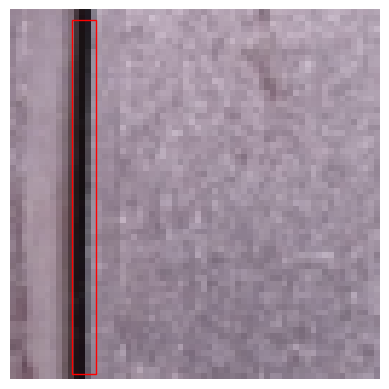

box : [ 4.571429   0.9142857 17.828571  63.54286  ] - label: 0


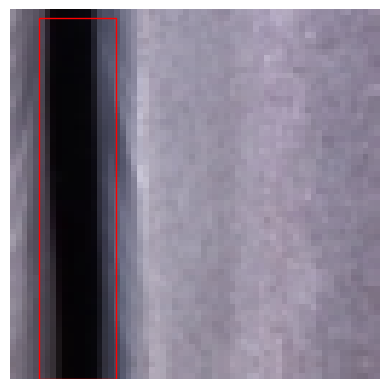

box : [ 0.22857143 17.6        16.914286   37.942856  ] - label: 0


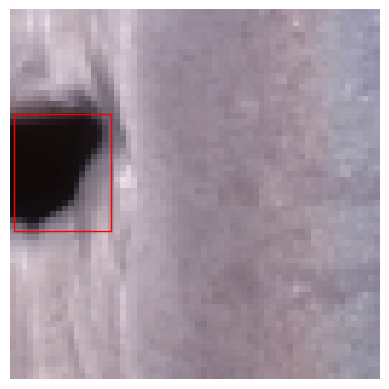

box : [ 5.0285716   0.22857143 10.514286   63.314285  ] - label: 0


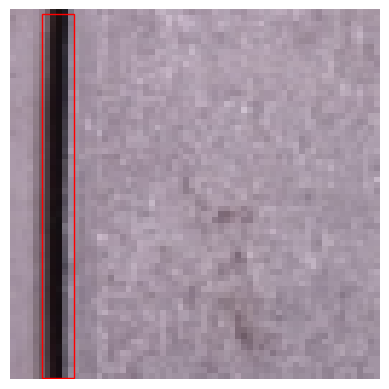

box : [15.085714   1.1428572 22.4       63.085712 ] - label: 0


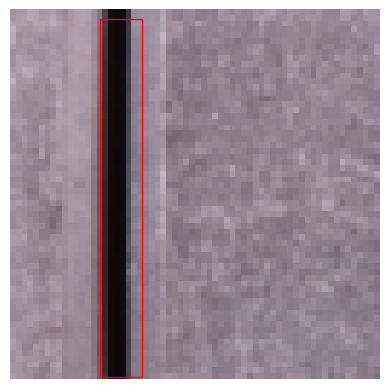

box : [14.857142   0.6857143 23.085714  63.771427 ] - label: 0


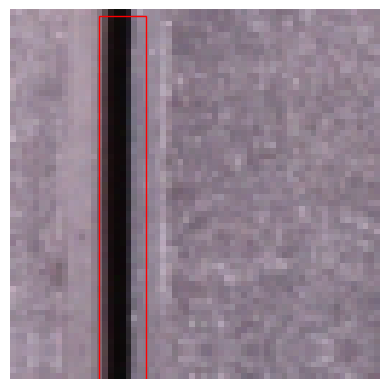

In [26]:
def show_tensor_image_with_box(tensor_image, box):
    # Convert from tensor to numpy
    numpy_image = tensor_image.permute(1, 2, 0).numpy()

    # Create figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(numpy_image)

    # Create a Rectangle patch
    # Unpack the box coordinates
    x_min, y_min, x_max, y_max = box
    
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.axis('off')  # Turn off axis numbers
    plt.show()

for i, [images, targets] in enumerate(train_loader):

    if len(images) > 0:
        first_image = images[0]
        first_target = targets[0]

        box = first_target['boxes'][0].cpu().numpy() 
        label = first_target['labels'][0].cpu().numpy() 
        print(f'box : {box} - label: {label}')
        show_tensor_image_with_box(first_image, box)
        if i == 5:
            break 

[10.285714   0.6857143 28.114286  62.4      ]


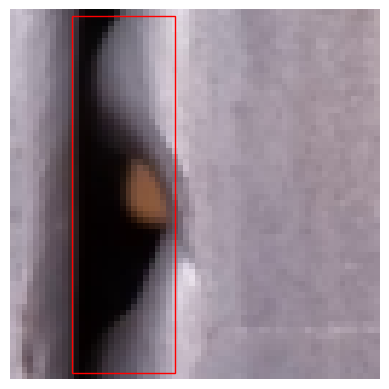

In [27]:
def show_tensor_image_with_box(tensor_image, box):
    # Convert from tensor to numpy
    numpy_image = tensor_image.permute(1, 2, 0).numpy()

    # Create figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(numpy_image)

    # Create a Rectangle patch
    # Unpack the box coordinates
    x_min, y_min, x_max, y_max = box
    
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.axis('off')  # Turn off axis numbers
    plt.show()

for images, targets in test_loader:

    if len(images) > 0:
        first_image = images[0]
        first_target = targets[0]

        box = first_target['boxes'][0].cpu().numpy() 
        print(box)
        show_tensor_image_with_box(first_image, box)
        break 

In [28]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

num_classes = 2
# Load a pre-trained model for common objects
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

for param in model.backbone.parameters():
    param.requires_grad = False
    
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)



In [29]:

from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the optimizer
from torchmetrics.detection.mean_ap import MeanAveragePrecision

metric = MeanAveragePrecision()

params = [p for p in model.parameters() if p.requires_grad]
# optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.8, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

model.to(device)

num_epochs = 25
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Calculate loss
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_train_loss += losses.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    if (epoch + 1) % 5 == 0:
        torch.save(model, f'model_epoch_{epoch+1}-img_size_{img_size}x.pth')
        print(f'Model saved at epoch {epoch+1}-{img_size}x')
        
    lr_scheduler.step()
    
    preds_single = []
    targets_single = []

    print(f"Epoch {epoch} - Average Training Loss: {avg_train_loss}")
    for batch_idx, (images, targets) in enumerate(test_loader, 1):
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        targets_single.extend(targets)

        model.eval()
        with torch.no_grad():
            pred = model(images)
        
        preds_single.extend(pred)
    
    metric.update(preds_single, targets_single)
    batch_map = metric.compute()
    val_losses.append(batch_map)
    print(f"Val mAP: {batch_map['map']}")
    torch.cuda.empty_cache()


Epoch 0 - Average Training Loss: 0.25619619749486444
Val mAP: 0.0
Epoch 1 - Average Training Loss: 0.06338160000741482
Val mAP: 0.0
Epoch 2 - Average Training Loss: 0.06073966696858406
Val mAP: 0.0
Epoch 3 - Average Training Loss: 0.05738964155316353
Val mAP: 0.0
Model saved at epoch 5-64x
Epoch 4 - Average Training Loss: 0.057421411573886874
Val mAP: 0.0
Epoch 5 - Average Training Loss: 0.05663736406713724
Val mAP: 0.0
Epoch 6 - Average Training Loss: 0.056989275570958856
Val mAP: 0.0
Epoch 7 - Average Training Loss: 0.057074354495853186
Val mAP: 0.0
Epoch 8 - Average Training Loss: 0.056059088371694085
Val mAP: 0.0
Model saved at epoch 10-64x
Epoch 9 - Average Training Loss: 0.055825323797762394
Val mAP: 0.0
Epoch 10 - Average Training Loss: 0.05714155472815037
Val mAP: 0.0
Epoch 11 - Average Training Loss: 0.05605403669178486
Val mAP: 0.0
Epoch 12 - Average Training Loss: 0.05655912663787603
Val mAP: 0.0
Epoch 13 - Average Training Loss: 0.05679186172783375
Val mAP: 0.0
Model saved 

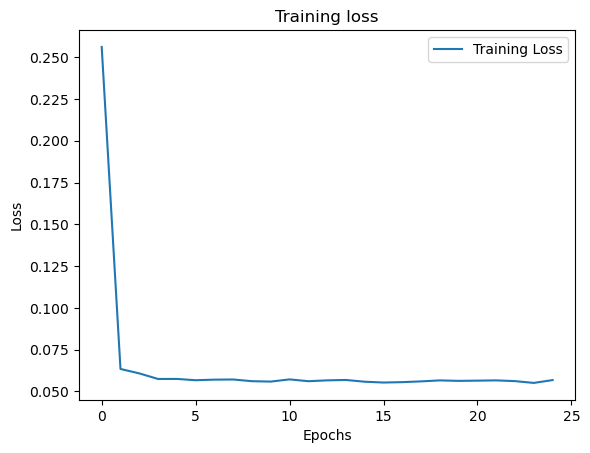

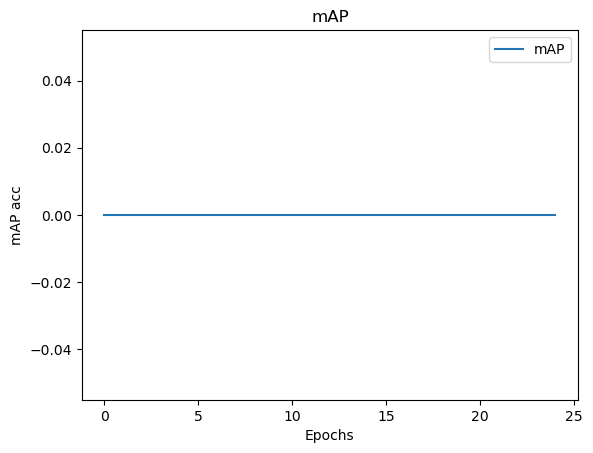

In [30]:
# Plotting the training and validation losses
mAP_values = [x['map'] for x in val_losses]
%matplotlib inline
plt.figure(1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(2)
plt.plot(mAP_values, label='mAP')
plt.title('mAP')
plt.xlabel('Epochs')
plt.ylabel('mAP acc')
plt.legend()
plt.show()

In [31]:
model.eval()  # Set model to evaluation mode
all_predictions = []
all_targets = []
test_images, test_preds = [], []

with torch.no_grad():
    for images, targets in test_loader:
        images = list(img.to(device) for img in images)
        predictions = model(images)
        print(predictions)
        all_predictions.extend(predictions)
        all_targets.extend(targets)
        test_images.extend(images)
        test_preds.extend(predictions)

[{'boxes': tensor([[6.3989e+01, 3.2293e+01, 6.4000e+01, 3.5981e+01],
        [6.3996e+01, 3.5491e+01, 6.4000e+01, 3.8707e+01],
        [6.3990e+01, 5.0448e+01, 6.4000e+01, 5.3969e+01],
        [6.3999e+01, 1.3529e+01, 6.4000e+01, 1.6845e+01],
        [6.3995e+01, 5.2496e+01, 6.4000e+01, 5.6065e+01],
        [6.3970e+01, 3.4838e+01, 6.4000e+01, 3.8121e+01],
        [6.3977e+01, 3.2594e+01, 6.4000e+01, 3.6270e+01],
        [6.3986e+01, 1.3185e+01, 6.4000e+01, 1.6536e+01],
        [6.3968e+01, 1.2452e+01, 6.4000e+01, 1.5974e+01],
        [6.3971e+01, 5.2858e+01, 6.4000e+01, 5.6440e+01],
        [6.3967e+01, 1.0953e+01, 6.4000e+01, 1.4867e+01],
        [6.3983e+01, 1.0345e+01, 6.4000e+01, 1.4238e+01],
        [6.3958e+01, 1.5877e-02, 6.3999e+01, 2.1645e+00],
        [6.3952e+01, 3.3366e+01, 6.3999e+01, 3.7037e+01],
        [6.3946e+01, 5.3114e+01, 6.3998e+01, 5.6742e+01],
        [6.3928e+01, 5.3152e-01, 6.3998e+01, 3.8815e+00]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# def show_image_with_boxes(image, boxes, labels):
#     # Convert tensor image to numpy and transpose from CxHxW to HxWxC
#     np_image = image.cpu().numpy().transpose(1, 2, 0)
#     np_image = np.clip(np_image, 0, 1)  # Clamp values to the valid range

#     fig, ax = plt.subplots(1)
#     ax.imshow(np_image)

#     for box, label in zip(boxes, labels):
#         xmin, ymin, xmax, ymax = box
#         rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
#                                  linewidth=2, edgecolor='r', facecolor='none')
#         ax.add_patch(rect)
#         plt.text(xmin, ymin, f'Class: {label}', bbox=dict(facecolor='white', alpha=0.5))

#     plt.show()

In [33]:
def show_image_with_boxes(image, boxes, labels):
    # Convert tensor image to numpy and transpose from CxHxW to HxWxC
    np_image = image.cpu().numpy().transpose(1, 2, 0)
    np_image = np.clip(np_image, 0, 1)  # Clamp values to the valid range

    fig, ax = plt.subplots(1)
    ax.imshow(np_image)

    # Check if boxes is not empty
    if boxes.size > 0:
        for box, label in zip(boxes, labels):
            # Unpack the box coordinates
            x_min, y_min, x_max, y_max = box
            # Create a Rectangle patch
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                     linewidth=4, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            # Optional: Add text label for each box
            plt.text(x_min, y_min, f'Class: {label}', bbox=dict(facecolor='white', alpha=0.5))
    else:
        print("No boxes to display.")

    plt.show()

[[6.3988754e+01 3.2293419e+01 6.4000000e+01 3.5981377e+01]
 [6.3996349e+01 3.5490925e+01 6.4000000e+01 3.8706963e+01]
 [6.3989914e+01 5.0448162e+01 6.4000000e+01 5.3968708e+01]
 [6.3998901e+01 1.3529294e+01 6.4000000e+01 1.6845425e+01]
 [6.3994827e+01 5.2496181e+01 6.4000000e+01 5.6065086e+01]
 [6.3969677e+01 3.4838306e+01 6.3999588e+01 3.8120945e+01]
 [6.3976933e+01 3.2593555e+01 6.3999714e+01 3.6270397e+01]
 [6.3985638e+01 1.3184581e+01 6.3999817e+01 1.6536266e+01]
 [6.3967831e+01 1.2451967e+01 6.3999580e+01 1.5973788e+01]
 [6.3971375e+01 5.2858479e+01 6.3999599e+01 5.6439945e+01]
 [6.3967045e+01 1.0952739e+01 6.3999565e+01 1.4867233e+01]
 [6.3982918e+01 1.0344758e+01 6.3999775e+01 1.4238396e+01]
 [6.3958279e+01 1.5877455e-02 6.3998913e+01 2.1644683e+00]
 [6.3951839e+01 3.3366314e+01 6.3998714e+01 3.7037342e+01]
 [6.3946289e+01 5.3113777e+01 6.3998379e+01 5.6742039e+01]
 [6.3928032e+01 5.3151780e-01 6.3997688e+01 3.8814611e+00]]


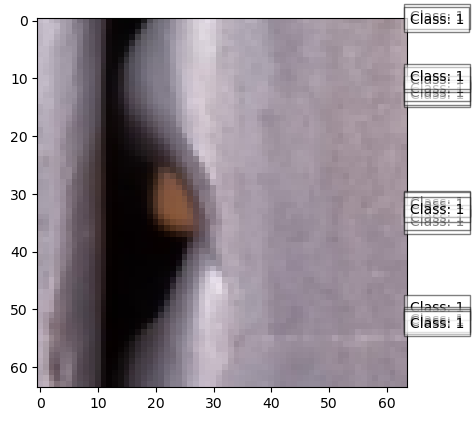

[[6.3989017e+01 4.5782646e+01 6.4000000e+01 5.0697285e+01]
 [6.3990414e+01 3.6869534e+01 6.4000000e+01 4.1290798e+01]
 [6.3994823e+01 4.4894100e+01 6.4000000e+01 5.0044197e+01]
 [6.3996838e+01 1.4137121e+01 6.4000000e+01 1.7658112e+01]
 [6.3992489e+01 2.2783491e+01 6.4000000e+01 2.7301186e+01]
 [6.3998310e+01 5.3062302e+01 6.4000000e+01 5.8554668e+01]
 [6.3971375e+01 3.9200958e+01 6.3999756e+01 4.3592514e+01]
 [6.3974045e+01 4.6545067e+01 6.3999729e+01 5.1178818e+01]
 [6.3983715e+01 3.7815327e+01 6.3999859e+01 4.2255131e+01]
 [6.3971470e+01 4.0528286e+01 6.3999748e+01 4.5364399e+01]
 [6.3965824e+01 7.0058056e-03 6.3999458e+01 9.2005110e-01]
 [6.3984905e+01 4.4552002e+01 6.3999859e+01 4.9732967e+01]
 [6.3976467e+01 2.2008152e+01 6.3999748e+01 2.6492531e+01]
 [6.3976971e+01 4.2575481e+01 6.3999783e+01 4.7771656e+01]
 [6.3974792e+01 3.6301418e+01 6.3999775e+01 4.0776707e+01]
 [6.3982414e+01 2.3184078e+01 6.3999809e+01 2.7625422e+01]
 [6.3982700e+01 5.2768372e+01 6.3999779e+01 5.8275482e+0

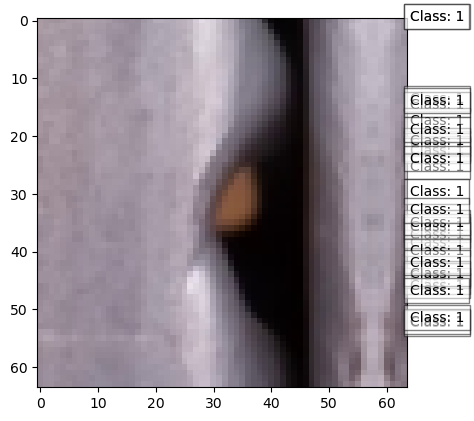

[[6.3998211e+01 3.4431427e+01 6.4000000e+01 3.8107719e+01]
 [6.3989609e+01 3.2825428e+01 6.4000000e+01 3.6532738e+01]
 [6.3996487e+01 5.0180149e+01 6.4000000e+01 5.3939182e+01]
 [6.3991821e+01 5.1065311e+01 6.4000000e+01 5.4964951e+01]
 [6.3997684e+01 5.0787724e+01 6.4000000e+01 5.4617538e+01]
 [6.3988598e+01 2.1014698e+00 6.4000000e+01 5.8601470e+00]
 [6.3992802e+01 1.6665084e+00 6.4000000e+01 5.0715485e+00]
 [6.3995640e+01 3.0190790e+00 6.4000000e+01 7.3741827e+00]
 [6.3986809e+01 1.7638244e-02 6.3999809e+01 2.1639948e+00]
 [6.3968090e+01 2.0377196e-02 6.3999535e+01 2.5374804e+00]
 [6.3971645e+01 3.3136089e+01 6.3999634e+01 3.6884441e+01]
 [6.3981609e+01 3.4085537e+01 6.3999763e+01 3.7686165e+01]
 [6.3969902e+01 7.2742458e-03 6.3999493e+01 8.9759338e-01]
 [6.3974812e+01 2.1898978e+00 6.3999599e+01 6.2058358e+00]
 [6.3954929e+01 6.2139738e-01 6.3998650e+01 3.4689062e+00]]


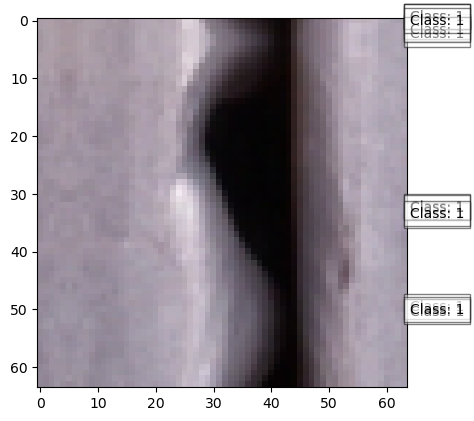

[[6.3993690e+01 1.9173475e+01 6.4000000e+01 2.3066122e+01]
 [6.3988754e+01 4.6247120e+01 6.4000000e+01 4.9858124e+01]
 [6.3994370e+01 4.5929726e+01 6.4000000e+01 4.9551113e+01]
 [6.3997036e+01 4.6471313e+01 6.4000000e+01 5.0145931e+01]
 [6.3998882e+01 4.5571922e+01 6.4000000e+01 4.9233467e+01]
 [6.3998940e+01 4.2333111e+01 6.4000000e+01 4.5965881e+01]
 [6.3998684e+01 6.0959253e+00 6.4000000e+01 1.0455756e+01]
 [6.3984505e+01 1.9561443e+01 6.3999836e+01 2.3354885e+01]
 [6.3976181e+01 2.0490437e+01 6.3999775e+01 2.4537546e+01]
 [6.3968636e+01 2.7239983e+01 6.3999573e+01 3.1587442e+01]
 [6.3969086e+01 2.9770466e+01 6.3999546e+01 3.3694630e+01]
 [6.3965668e+01 2.5417580e+01 6.3999535e+01 2.9967175e+01]
 [6.3986103e+01 3.0571764e+01 6.3999794e+01 3.4353191e+01]
 [6.3968132e+01 5.8396107e+01 6.3999451e+01 6.2405529e+01]
 [6.3975334e+01 1.2862440e+01 6.3999660e+01 1.7326616e+01]
 [6.3982899e+01 5.6794334e+01 6.3999706e+01 6.0952087e+01]
 [6.3963936e+01 1.9891954e+01 6.3999207e+01 2.3686087e+0

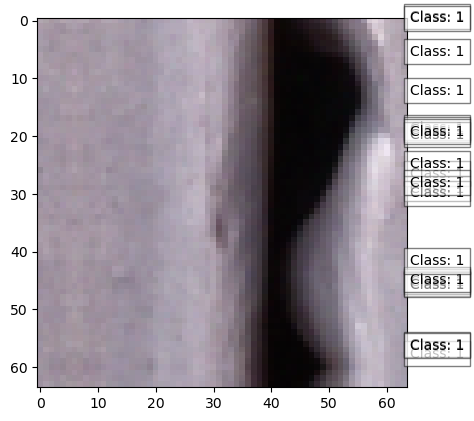

[[6.3933445e+01 5.7943497e-02 6.3997540e+01 2.5221045e+00]]


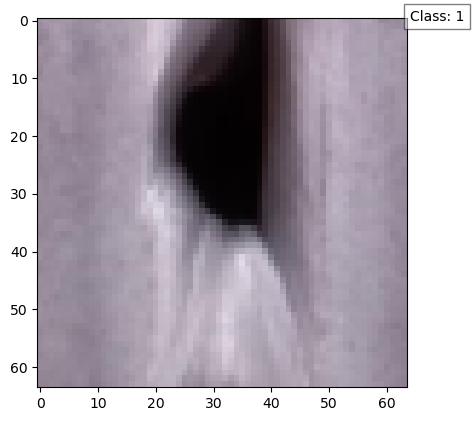

[[63.995564 13.556397 64.       17.369816]
 [63.99092  33.95111  64.       37.646072]
 [63.98265  33.585445 63.999767 37.361656]]


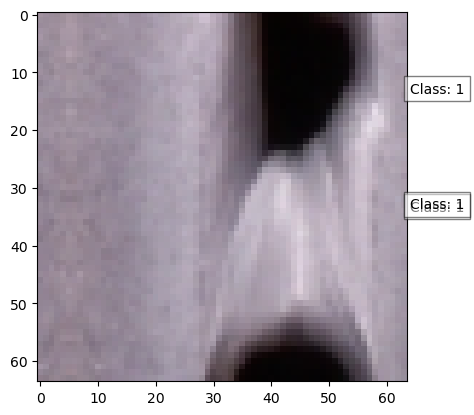

[[63.92854     0.06848404 63.997192    2.9489527 ]]


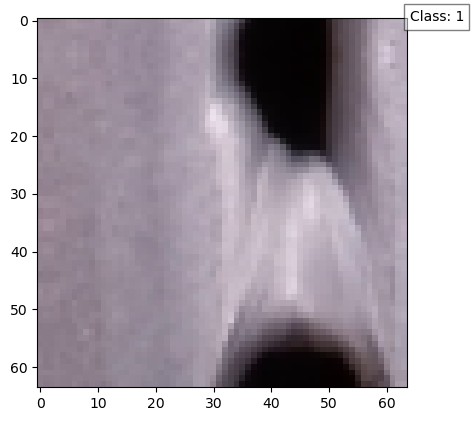

[[63.994442   5.273893  64.        10.65124  ]
 [63.984077  54.678406  63.999817  60.298428 ]
 [63.976677   4.303531  63.9998     9.825736 ]
 [63.94764   54.905994  63.998695  60.535995 ]
 [63.96108    3.0366821 63.999252   8.622846 ]]


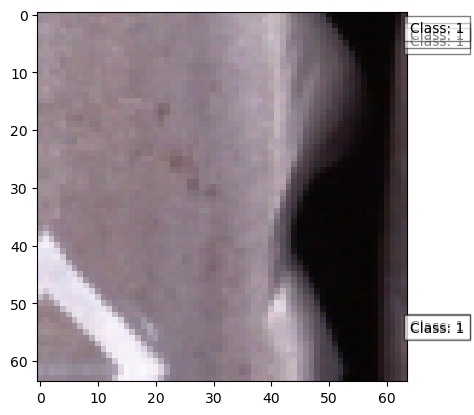

[[6.39928589e+01 1.48860035e+01 6.40000000e+01 1.85034294e+01]
 [6.39948921e+01 2.05369968e+01 6.40000000e+01 2.43785248e+01]
 [6.39986496e+01 2.08127975e+01 6.40000000e+01 2.46585941e+01]
 [6.39973564e+01 4.50269814e+01 6.40000000e+01 4.86432915e+01]
 [6.39909782e+01 1.57476034e+01 6.40000000e+01 1.94346218e+01]
 [6.39904518e+01 2.46048241e+01 6.40000000e+01 2.84042530e+01]
 [6.39977074e+01 2.38923645e+01 6.40000000e+01 2.77481365e+01]
 [6.39966507e+01 2.49637299e+01 6.40000000e+01 2.87276077e+01]
 [6.39939575e+01 2.52785931e+01 6.40000000e+01 2.90251999e+01]
 [6.39709053e+01 4.56170883e+01 6.39997063e+01 4.92828293e+01]
 [6.39851265e+01 4.53171997e+01 6.39998436e+01 4.89482155e+01]
 [6.39796906e+01 1.94686130e-02 6.39997025e+01 2.38156772e+00]
 [6.39711647e+01 5.09949265e+01 6.39997025e+01 5.49006691e+01]
 [6.39811211e+01 1.51547909e+01 6.39997940e+01 1.88415947e+01]
 [6.39868202e+01 8.08763742e-01 6.39997978e+01 4.02963257e+00]
 [6.39880791e+01 3.18600821e+00 6.39998283e+01 7.108226

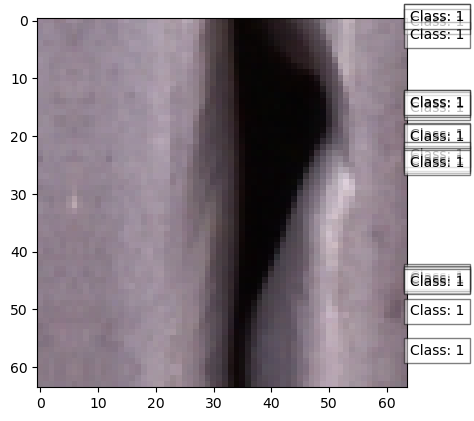

[[63.997936 16.900055 64.       20.216225]
 [63.99043  16.631273 64.       20.037382]
 [63.977493 18.915878 63.99971  22.289072]
 [63.983356 15.605739 63.999775 19.155313]
 [63.95581  19.258112 63.99878  22.64796 ]]


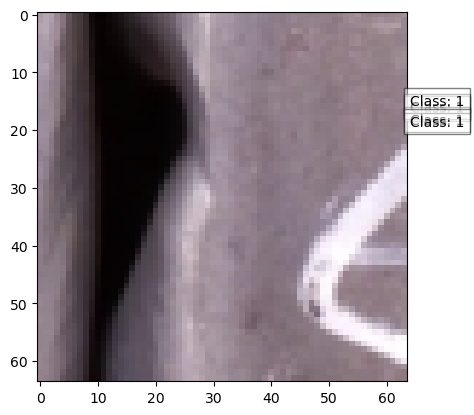

In [34]:
for image, prediction in zip(test_images[:10], test_preds[:10]):  # Display first 10 images
    boxes = prediction['boxes'].cpu().detach().numpy()
    labels = prediction['labels'].cpu().detach().numpy()
    print(boxes)
    show_image_with_boxes(image, boxes, labels)
